# Quickstart

This notebook demonstrates how you can find adversarial examples for a pre-trained example network on the MNIST dataset.

We suggest having the `Gurobi` solver installed, since its performance is significantly faster. If this is not possible, the `Cbc` solver is another option.

The `Images` package is only necessary for visualizing the sample images.

In [1]:
using MIPVerify
using Cbc
using Images

## Setup

### MNIST dataset

We begin by loading the MNIST dataset. The data is provided as a Julia `struct` for easy access. The training images and test images are provided as a 4-dimensional array of size `(num_samples, height, width, num_channels)`.

In [2]:
mnist = MIPVerify.read_datasets("MNIST")

mnist:
  `train`: {LabelledImageDataset}
    `images`: 60000 images of size (28, 28, 1), with pixels in [0.0, 1.0].
    `labels`: 60000 corresponding labels, with 10 unique labels in [0, 9].
  `test`: {LabelledImageDataset}
    `images`: 10000 images of size (28, 28, 1), with pixels in [0.0, 1.0].
    `labels`: 10000 corresponding labels, with 10 unique labels in [0, 9].

In [3]:
mnist.train

{LabelledImageDataset}
    `images`: 60000 images of size (28, 28, 1), with pixels in [0.0, 1.0].
    `labels`: 60000 corresponding labels, with 10 unique labels in [0, 9].

In [4]:
size(mnist.train.images)

(60000, 28, 28, 1)

In [5]:
mnist.train.labels

60000-element Vector{UInt8}:
 0x05
 0x00
 0x04
 0x01
 0x09
 0x02
 0x01
 0x03
 0x01
 0x04
 0x03
 0x05
 0x03
    ⋮
 0x07
 0x08
 0x09
 0x02
 0x09
 0x05
 0x01
 0x08
 0x03
 0x05
 0x06
 0x08

### Sample Neural Network

We import a sample pre-trained neural network. 

In [6]:
n1 = MIPVerify.get_example_network_params("MNIST.n1")

sequential net MNIST.n1
  (1) Flatten(): flattens 4 dimensional input, with dimensions permuted according to the order [4, 3, 2, 1]
  (2) Linear(784 -> 40)
  (3) ReLU()
  (4) Linear(40 -> 20)
  (5) ReLU()
  (6) Linear(20 -> 10)


`MIPVerify.frac_correct` allows us to verify that the network has a reasonable accuracy on the test set of 96.95%. (This step is crucial when working with your own neural net parameters; since the training is done outside of Julia, a common mistake is to transfer the parameters incorrectly.)

In [7]:
MIPVerify.frac_correct(n1, mnist.test, 10000)

Computing fraction correct...100%|██████████████████████| Time: 0:00:02


0.9695

We feed the first image into the neural net, obtaining the activations of the final softmax layer. 

Note that the image must be specified as a 4-dimensional array with size `(1, height, width, num_channels)`. We provide a helper function `MIPVerify.get_image` that extracts the image from the dataset while preserving all four dimensions.

In [8]:
sample_image = MIPVerify.get_image(mnist.test.images, 1)

1×28×28×1 Array{Float64, 4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

;;; … 

[:, :, 26, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 27, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 28, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [9]:
output_activations = sample_image |> n1

10-element Vector{Float64}:
 -0.02074390040759505
 -0.017499541361042703
  0.16707187742051954
 -0.05323712887827292
 -0.019291011852467455
 -0.07951546424946399
  0.06191130931372918
  4.833970937815984
  0.46706000134294867
  0.40145201599055125

The category that has the largest activation is category 8, corresponding to a label of 7.

In [10]:
(output_activations |> MIPVerify.get_max_index) - 1

7

This matches the true label.

In [11]:
MIPVerify.get_label(mnist.test.labels, 1)

7

## Finding an Adversarial Example

We now try to find the closest $L_infty$ norm adversarial example to the first image, setting the target category as index `10` (corresponding to a true label of 9). Note that we restrict the search space to a distance of `0.05` around the original image via the specified `pp`.

In [12]:
target_label_index = 10
d = MIPVerify.find_adversarial_example(
    n1, 
    sample_image, 
    target_label_index, 
    Cbc.Optimizer, 
    Dict(),
    norm_order = Inf,
    pp=MIPVerify.LInfNormBoundedPerturbationFamily(0.05)
)

[notice | MIPVerify]: Attempting to find adversarial example. Neural net predicted label is 8, target labels are [10]
[notice | MIPVerify]: Determining upper and lower bounds for the input to each non-linear unit.


  Calculating upper bounds: 100%|███████████████████████| Time: 0:00:00
  Calculating lower bounds: 100%|███████████████████████| Time: 0:00:00
  Imposing relu constraint: 100%|███████████████████████| Time: 0:00:00
  Calculating upper bounds: 100%|███████████████████████| Time: 0:01:02
  Calculating lower bounds: 100%|███████████████████████| Time: 0:01:10


Welcome to the CBC MILP Solver 
Version: 2.10.5 
Build Date: Dec  4 2021 

command line - Cbc_C_Interface -solve -quit (default strategy 1)
Continuous objective value is 0 - 0.08 seconds
Cgl0004I processed model has 1782 rows, 1629 columns (30 integer (30 of which binary)) and 51130 elements
Cbc0038I Initial state - 19 integers unsatisfied sum - 5.56088
Cbc0038I Pass   1: suminf.    0.48013 (3) obj. 0.05 iterations 1498
Cbc0038I Pass   2: suminf.    0.18217 (2) obj. 0.05 iterations 357
Cbc0038I Pass   3: suminf.    0.35648 (3) obj. 0.05 iterations 705
Cbc0038I Pass   4: suminf.    0.34748 (3) obj. 0.05 iterations 80
Cbc0038I Pass   5: suminf.    0.12292 (1) obj. 0.05 iterations 1546
Cbc0038I Pass   6: suminf.    0.01536 (1) obj. 0.05 iterations 457
Cbc0038I Pass   7: suminf.    0.71395 (3) obj. 0.05 iterations 649
Cbc0038I Pass   8: suminf.    0.16780 (1) obj. 0.05 iterations 1176
Cbc0038I Pass   9: suminf.    0.00064 (1) obj. 0.05 iterations 590
Cbc0038I Pass  10: suminf.    0.00064 (

Dict{Any, Any} with 11 entries:
  :TargetIndexes      => [10]
  :SolveTime          => 20.4111
  :TotalTime          => 163.883
  :Perturbation       => [noname noname … noname noname;;; noname noname … nona…
  :PerturbedInput     => [noname noname … noname noname;;; noname noname … nona…
  :TighteningApproach => "mip"
  :PerturbationFamily => linf-norm-bounded-0.05
  :SolveStatus        => OPTIMAL
  :Model              => A JuMP Model…
  :Output             => JuMP.AffExpr[-0.012063867412507534 noname + 0.66065257…
  :PredictedIndex     => 8

In [13]:
using JuMP

perturbed_sample_image = JuMP.value.(d[:PerturbedInput])

1×28×28×1 Array{Float64, 4}:
[:, :, 1, 1] =
 0.0460847  0.0  0.0  0.0460847  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0460847

[:, :, 2, 1] =
 0.0  0.0  0.0  0.0460847  0.0460847  0.0  …  0.0  0.0  0.0  0.0  0.0460847

[:, :, 3, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0460847  …  0.0  0.0  0.0460847  0.0  0.0

;;; … 

[:, :, 26, 1] =
 0.0  0.0  0.0460847  0.0  0.0  0.0  0.0  …  0.0460847  0.0460847  0.0  0.0

[:, :, 27, 1] =
 0.0460847  0.0460847  0.0  0.0  0.0  0.0  …  0.0460847  0.0  0.0460847

[:, :, 28, 1] =
 0.0460847  0.0  0.0460847  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0460847  0.0

As a sanity check, we feed the perturbed image into the neural net and inspect the activation in the final layer. We verify that the perturbed image does maximize the activation of the target label index, which is 10.

In [14]:
perturbed_sample_image |> n1

10-element Vector{Float64}:
  0.674945062874554
  0.6179790360668571
  0.39303215980893846
  0.2965618596703594
  0.24101053495483016
  0.16060021203574187
  0.5428526100447271
  4.288351484573888
 -0.2264301823307634
  4.288351484573882

We visualize the perturbed image and compare it to the original image. Since we are minimizing the $L_infty$-norm, changes are made to many pixels but the change to each pixels is not very noticeable.

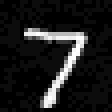

In [15]:
colorview(Gray, perturbed_sample_image[1, :, :, 1])

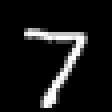

In [16]:
colorview(Gray, sample_image[1, :, :, 1])

That concludes this quickstart! The next tutorial will introduce you to each of the layers, and show how you can import your own neural network parameters.